# Neural Network on FashionMNIST Dataset using PyTorch

In this notebook, we will implement Neural Networks on the FashionMNIST dataset using PyTorch.

## 1. Preparations

#### Import packages:

In [1]:
import collections
import random

import torch
import torchvision

import matplotlib.pyplot as plt

#### Write the device-agnostic code:

In [2]:
# With mps:
device = "mps" if torch.backends.mps.is_available() else "cpu"

# With cuda:
# device = "cuda" if torch.cuda.is_available() else "cpu"

#### Set up the hyperparameters:

In [3]:
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.001

## 2. Data

#### Create the data transform:

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

#### Obtain the training and testing datasets:

In [5]:
# Obtain the training dataset:
train_data = torchvision.datasets.FashionMNIST(root="train", train=True, transform=transform, download=True)

# Obtain the testing dataset:
test_data = torchvision.datasets.FashionMNIST(root="test", train=False, transform=transform, download=True)

100.0%


Extracting train/FashionMNIST/raw/train-images-idx3-ubyte.gz to train/FashionMNIST/raw



100.0%


Extracting train/FashionMNIST/raw/train-labels-idx1-ubyte.gz to train/FashionMNIST/raw



100.0%


Extracting train/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to train/FashionMNIST/raw



100.0%


Extracting train/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to train/FashionMNIST/raw



100.0%


Extracting test/FashionMNIST/raw/train-images-idx3-ubyte.gz to test/FashionMNIST/raw



100.0%


Extracting test/FashionMNIST/raw/train-labels-idx1-ubyte.gz to test/FashionMNIST/raw



100.0%


Extracting test/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to test/FashionMNIST/raw



100.0%

Extracting test/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to test/FashionMNIST/raw



#### Create balanced datasets:

In [6]:
# Define a function to create a balanced dataset from the given data:
def create_balanced_dataset(data: torch.utils.data.Dataset):

    # Create a dictionary that maps class labels to indices of samples that are associated to this class:
    data_class_labels_to_sample_indices = collections.defaultdict(list)
    for sample_idx, (X, y) in enumerate(data):
        data_class_labels_to_sample_indices[y].append(sample_idx)

    # Find the class that has the minimum number of data samples:
    min_samples = min(len(indices) for indices in data_class_labels_to_sample_indices.values())

    # Randomly pick `min_samples` samples' indices from each class:
    balanced_data_indices = []
    for indices in data_class_labels_to_sample_indices.values():
        sample_indices = random.sample(indices, min_samples)
        balanced_data_indices.extend(sample_indices)

    # Create a balanced dataset:
    balanced_data = torch.utils.data.Subset(data, balanced_data_indices)
    
    return balanced_data

In [7]:
# Create balanced training datasets:
balanced_train_data = create_balanced_dataset(train_data)

Note that we don't want balanced testing dataset since it's used to evaluate the model's performance on real-world data distributions.

#### Make the dataloaders:

In [8]:
# Create a dataloader for the training data using the balanced training dataset:
train_dataloader = torch.utils.data.DataLoader(
    dataset=balanced_train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [9]:
# Create a dataloader for the testing data:
test_dataloader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE
)

Note that we don't want to shuffle the testing dataset since it's used to evaluate the model's performance on real-world data distributions.

#### Take a look at the data:

In [10]:
# Iterate through the dataloader of the training dataset:
data_iter = iter(train_dataloader)
images, labels = next(data_iter)

In [11]:
# Show the shapes of the image data and labels:
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

Explanations:

- `torch.Size([64, 1, 28, 28])` means that in this batch there are `64` images each of shape `(1, 28, 28)` [`(batch_size, color_channels, height, width)`].

- `torch.Size([64])` means that there are `64` class labels in this batch.

In [12]:
# Get a dictionary that maps class names to class labels:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [13]:
# Get a list of all class names:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [14]:
# Get the total number of classes:
num_classes = len(class_to_idx)
num_classes

10

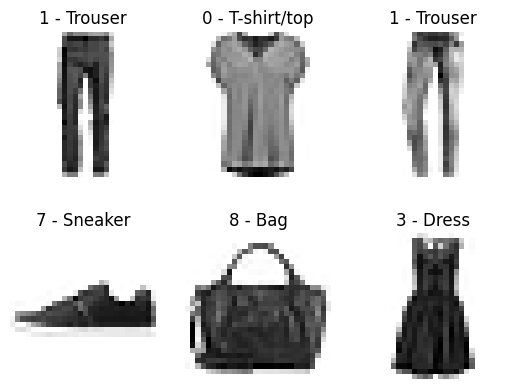

In [15]:
# Show the first 6 images and their class names in this batch:
figure = plt.figure()
num_of_images = 6
for i in range(1, num_of_images + 1):
    plt.subplot(2, 3, i)
    plt.axis("off")
    plt.imshow(images[i].numpy().squeeze(), cmap="gray_r")
    label = labels[i].item()
    plt.title(f"{label} - {class_names[label]}")
plt.show()

## 3. Neural Network Model

#### Build the Neural Network model:

In [16]:
class NN_Model(torch.nn.Module):

    def __init__(self, input_features: int, hidden_features: int, output_features: int) -> None:

        super().__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(
                in_features=input_features,
                out_features=hidden_features
            ),
            torch.nn.ReLU(),
            torch.nn.Linear(
                in_features=hidden_features,
                out_features=hidden_features
            ),
            torch.nn.ReLU(),
            torch.nn.Linear(
                in_features=hidden_features,
                out_features=output_features
            )
        )

    def forward(self, X):
        return self.layers(X)

## 4. Training and Testing

#### Define functions for each training and testing step:

In [17]:
# Define a function for each training step:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str
) -> tuple[float, float]:
    
    # Initialize the training loss and accuracy:
    train_loss, train_acc = 0, 0

    # Set the model in training mode:
    model.train()

    for batch_idx, (X, y) in enumerate(dataloader):  # Iterate over batches of the dataloader
        
        # Send `X` and `y` to `device`:
        X, y = X.to(device), y.to(device)  

        # Perform a forward pass, which computes the model's predictions on the input `X`:
        y_pred_logits = model(X)

        # Calculate the loss:
        loss = loss_fn(y_pred_logits, y)

        # Accumulate the loss:
        train_loss += loss.item()

        # Reset the gradients of all optimized parameters:
        optimizer.zero_grad()

        # Perform a backward pass, which computes gradients of the loss with respect to all parameters that have `requires_grad=True`:
        loss.backward()

        # Perform a single optimization step, which updates the model's parameters based on the computed gradients:
        optimizer.step()

        # Find the predicted class label from the logits:
        y_pred = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
        
        # Accumulate the training accuracy:
        train_acc += (y_pred == y).sum().item() / len(y_pred_logits)

    # Adjust the metrics to get the average loss and accuracy per batch:
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

In [18]:
# Define a function for each training step:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: str
) -> tuple[float, float]:
    
    # Initialize the testing loss and accuracy:
    test_loss, test_acc = 0, 0

    # Set the model in evaluation mode:
    model.eval()

    with torch.inference_mode():  # Enable inference mode
        
        for batch_idx, (X, y) in enumerate(dataloader):  # Iterate over batches of the dataloader
            
            # Send `X` and `y` to `device`:
            X, y = X.to(device), y.to(device)

            # Perform a forward pass, which computes the model's predictions on the input `X`:
            y_pred_logits = model(X)
            
            # Calculate the loss:
            loss = loss_fn(y_pred_logits, y)

            # Accumulate the loss:
            test_loss += loss.item()

            # Get the predicted class label from the logits:
            y_pred = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)

            # Accumulate the testing accuracy:
            test_acc += (y_pred == y).sum().item() / len(y_pred_logits)

    # Adjust the metrics to get the average loss and accuracy per batch:
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    
    return test_loss, test_acc

#### Define a function for training and testing the model:

In [19]:
def train_test_model(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: str
) -> dict[str, list]:
    
    # Initialize the loss and accuracy of training and testing:
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in range(epochs):  # Iterate over the epochs

        # Perform the training step:
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        # Perform the testing step:
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        # Print the training and testing information:
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")

        # Accumulate the loss and accuracy:
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

#### Train and test the model:

In [20]:
# Set up the model:
model = NN_Model(input_features=28*28, hidden_features=100, output_features=num_classes).to(device)  # The input shape is `28*28` since the data images have shape 28x28

# Define the loss function and optimizer:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Train and test the model, and obtain the results:
results = train_test_model(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS,
    device=device
)

Epoch: 0 | Train loss: 0.5666 | Train accuracy: 0.7993 | Test loss: 0.4037 | Test accuracy: 0.8590
Epoch: 1 | Train loss: 0.3961 | Train accuracy: 0.8585 | Test loss: 0.3782 | Test accuracy: 0.8582
Epoch: 2 | Train loss: 0.3544 | Train accuracy: 0.8711 | Test loss: 0.3249 | Test accuracy: 0.8801
Epoch: 3 | Train loss: 0.3282 | Train accuracy: 0.8791 | Test loss: 0.2962 | Test accuracy: 0.8909
Epoch: 4 | Train loss: 0.3095 | Train accuracy: 0.8843 | Test loss: 0.3158 | Test accuracy: 0.8817
Epoch: 5 | Train loss: 0.2942 | Train accuracy: 0.8909 | Test loss: 0.2713 | Test accuracy: 0.8986
Epoch: 6 | Train loss: 0.2818 | Train accuracy: 0.8964 | Test loss: 0.2690 | Test accuracy: 0.9005
Epoch: 7 | Train loss: 0.2684 | Train accuracy: 0.8990 | Test loss: 0.2512 | Test accuracy: 0.9068
Epoch: 8 | Train loss: 0.2586 | Train accuracy: 0.9028 | Test loss: 0.2442 | Test accuracy: 0.9085
Epoch: 9 | Train loss: 0.2485 | Train accuracy: 0.9056 | Test loss: 0.2608 | Test accuracy: 0.9001
Epoch: 10 

#### Plot the loss and accuracy curves:

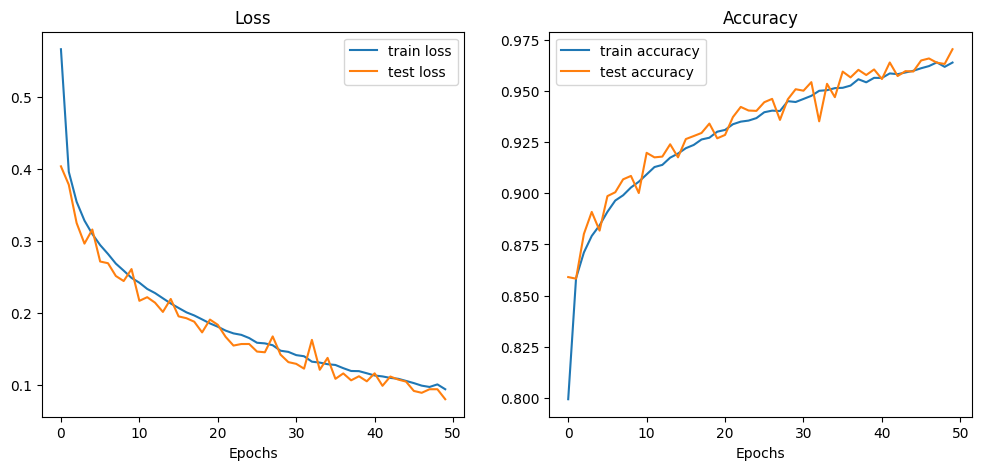

In [21]:
train_loss = results["train_loss"]
test_loss = results["test_loss"]
train_acc = results["train_acc"]
test_acc = results["test_acc"]
epochs = range(EPOCHS)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="train loss")
plt.plot(epochs, test_loss, label="test loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="train accuracy")
plt.plot(epochs, test_acc, label="test accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.show()

We can see that the training and testing loss are both decreasing, and the training and testing accuracy are both increasing. This is the ideal behavior.

#### Save the model to a file and load it:

In [22]:
# Save the model's `state_dict` to a file:
model_state_dict_path = "model_state_dict.pt"
torch.save(model.state_dict(), model_state_dict_path)

In [23]:
# Set up the new model for loading the `state_dict`:
model_load = NN_Model(input_features=28*28, hidden_features=100, output_features=num_classes).to(device)

# Load the saved model:
model_load.load_state_dict(torch.load(model_state_dict_path))

<All keys matched successfully>

#### Use the loaded model to make predictions:

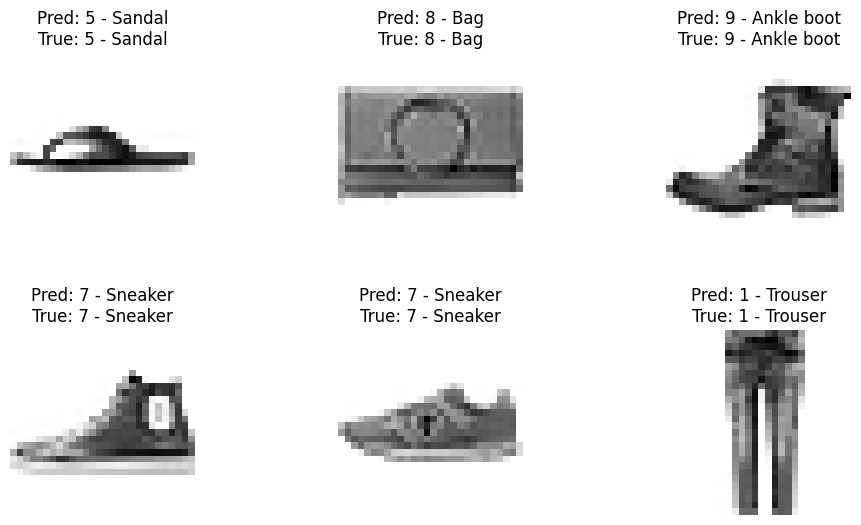

In [24]:
# Set the model in evaluation mode:
model_load.eval()

# Randomly pick 6 images from testing dataset with their true labels:
random_indices = random.sample(range(len(test_data)), 6)
selected_images = [test_data[idx][0] for idx in random_indices]
true_labels = [test_data[idx][1] for idx in random_indices]

fig = plt.figure(figsize=(12, 6))

for i in range(6):
    # Get the image and the true label:
    image = selected_images[i]
    y_true = true_labels[i]

    # Make a prediction on the image:
    with torch.inference_mode():
        image = image.unsqueeze(dim=0).to(device)
        y_pred_logits = model_load(image)

    # Get the predicted class label from the prediction logits:
    y_pred = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1).item()

    # Get the predicted class name and the true class name:
    class_name_pred = class_names[y_pred]
    class_name_true = class_names[y_true]

    plt.subplot(2, 3, i + 1)
    plt.axis("off")
    plt.imshow(image.cpu().numpy().squeeze(), cmap="gray_r")
    plt.title(f"Pred: {y_pred} - {class_name_pred}\nTrue: {y_true} - {class_name_true}")

plt.subplots_adjust(hspace=0.5)
plt.show()

Here we can see that in this specific experiment all the predictions are correct.